# Classification

### Collect training features

In [41]:
import numpy as np
import random
import os, sys
import warnings

from matplotlib import pyplot as plt

from classifier import Classifier
from env_variables import *
from dataset.loading import DataLoader

random.seed(0)
np.random.seed(0)
warnings.filterwarnings("ignore")

directory = os.path.abspath('/Users/joris/Documents/Work/bsc ai/bt/Bachelor-Thesis/code')
sys.path.append(directory)

data_path = '../../../'
dl = DataLoader(data_path)

dr = []
speakers = []
XorZ = "Z"
long_version = False
n_mels = 14
delta = False
delta_delta = False
subsamples = 10
const_params = {
    "n_mels":n_mels,
    "XorZ":XorZ,
    "N":100
}

path_option = "Final"+str(long_version)+str(n_mels)+str(delta)+str(delta_delta)+str(subsamples)

if dr:
    path_option = str(dr)+"_"+path_option
if len(speakers):
    path_option = str(speakers[0])+"_"+path_option

features_train, labels_train, _ = dl.collectFeaturesInSegments(
    n_mels=n_mels, delta=delta, delta_delta=delta_delta,
    long_version=long_version, speakers=speakers, dr=dr,
    subsamples=subsamples, path_option=path_option)

-from output
---- success


### Regroup data and subset phonemes

In [42]:
from dataset.data_processing import *

phonemes, features_train, labels_train = filter_data(features_train, labels_train, limit=200)

Filtered to 7800 samples of shape (10, 14)


### Classification

#### Training

In [3]:
clas = Classifier(W_in_scale=1.5,
                 b_scale=.2,
                 spectral_radius=1.5,
                 weights=.1)

clas.fit(features_train, labels_train, **{
    "n_mels": n_mels,
    "XorZ": "X",
    "N": 50
})

Number of samples: 7800
- computing conceptors
optimizing
Computing gammas...
Optimal gamma:  53.81388683982854
normalizing
Target:  19.73491779423485
std 0.5170518395124576
- computing negative conceptors


Classifier(W_in_scale=1.5, b_scale=0.2, spectral_radius=1.5, weights=0.1)

#### Testing

In [4]:
print("Testing...")

features_test, labels_test, _ = dl.collectFeaturesInSegments(
    ft='Test',n_mels=n_mels,delta=delta,delta_delta=delta_delta,
    long_version=long_version,speakers=[],dr=dr,sentence=[],
    subsamples=subsamples,path_option=path_option+"_test")

_, features_test, labels_test = filter_data(features_test, labels_test, limit=None)

print(f'Training Accuracy of x : {clas.score(features_train, labels_train)}')
print(f'Test Accuracy of x     : {clas.score(features_test, labels_test)}')

Testing...
-from output
---- success
Filtered to 64145 samples of shape (10, 14)
Training Accuracy of x : 0.4958974358974359
Test Accuracy of x     : 0.47961649388105076


#### Displaying Confusion Matrix

In [110]:
from sklearn.metrics import confusion_matrix

labels_pred = clas.predict(features_test)

KeyboardInterrupt: 

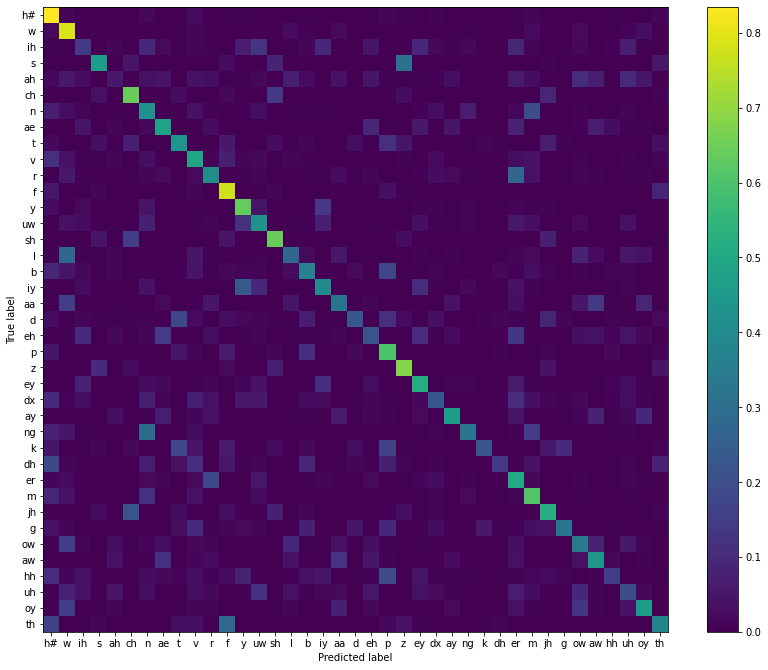

In [115]:
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(labels_test, labels_pred, labels=phonemes, normalize='true')
disp = ConfusionMatrixDisplay(cm, display_labels=phonemes)
fig, ax = plt.subplots(figsize=(14,11.5))

disp.plot(ax=ax, include_values=False)

# Extras

#### Z-Classification

In [8]:
clas2 = Classifier(1.5, .2, 1.5, .1) # Z optimal params

clas2.fit(features_train, labels_train, **{
    "n_mels":n_mels,
    "XorZ":"X",
    "N":20
})

print(f'Training Accuracy of z : {clas2.score(features_train, labels_train)}')
print(f'Test Accuracy of z     : {clas2.score(features_test, labels_test)}')

Number of samples: 7800
- computing conceptors
optimizing
Computing gammas...
Optimal gamma:  36.63744877646322
normalizing
Target:  12.309827296551376
std 0.3657711343880806
- computing negative conceptors
Training Accuracy of z : 0.43064102564102563
Test Accuracy of z     : 0.45510951749941536


#### Bayesian Hyperparameter Tuning

In [9]:
from sklearn.model_selection import train_test_split
from bayes_opt import BayesianOptimization

X_train, X_test, y_train, y_test = train_test_split(features_train,
                                                    labels_train,
                                                    stratify = labels_train,
                                                    random_state = 1)

# Bayesian Optimization wrapper
def objective_function(W_in_scale,
                       b_scale,
                       spectral_radius,
                       weights):

    model = Classifier(W_in_scale,
                 b_scale,
                 spectral_radius,
                 weights)
    model.fit(X_train, y_train, **const_params)
    return model.score(X_test, y_test)


parameters = {
    'W_in_scale': [.01, 2],
    'spectral_radius': [0.01, 4],
    'b_scale': [0, 2],
    'weights': [.01,1]
}

# Bayesian optimization of the objective function.
optimizer = BayesianOptimization(f = objective_function,
                                 pbounds = parameters,
                                 random_state = 0)
optimizer.maximize(init_points = 10, n_iter = 100)

best_params = optimizer.max['params']
print(f"Best parmaters: {best_params}; f(x) = {optimizer.max['target']}.")


# Scikitlearn
#opt = Classifier()
#opt = BayesSearchCV(Classifier(), parameters, n_iter=50, cv=3)
#opt.fit(features, labels, **{
#   "in_dim":n_mels,
#   "out_dim":n_mels
#})
#print(opt.score(fv, lv))
#print(opt.best_params_)

|   iter    |  target   | W_in_s... |  b_scale  | spectr... |  weights  |
-------------------------------------------------------------------------
Number of samples: 5850
- computing conceptors
optimizing
Computing gammas...


KeyboardInterrupt: 

In [ ]:
#with open('res.txt','x') as file:
#    file.write(opt.score(fv,lv))
#    file.write(opt.best_params_)

#### Plotting Progress

In [ ]:
plt.rcParams['text.usetex'] = True
fig, ax1 = plt.subplots(figsize = (15, 5))

ax2 = ax1.twinx()

# Scores:
ax1.plot(range(1, 1 + len(optimizer.space.target)), optimizer.space.target, color='r', label="Accuracy - $f(\\rho$, $k_{W^in}$, $k_b$, $r$)")

# Parameters
W_in_scale = []
b_scale = []
spectral_radius = []
weights = []

for res in optimizer.res:
    W_in_scale.append(res["params"]["W_in_scale"])
    b_scale.append(res["params"]["b_scale"])
    spectral_radius.append(res["params"]["spectral_radius"])
    weights.append(res["params"]["weights"])

if True:
    ax1.plot(range(1, 1 + len(optimizer.space.target)), W_in_scale, "--", label="$W^{in}$")
    ax1.plot(range(1, 1 + len(optimizer.space.target)), b_scale, "--", label="$k_b$")
    ax1.plot(range(1, 1 + len(optimizer.space.target)), spectral_radius, "--", label="$r$")
    ax1.plot(range(1, 1 + len(optimizer.space.target)), weights, "--", label="$\\rho$")

ax1.set_xlabel('Iteration', fontsize = 20)
ax1.set_ylabel('Accuracy', color="r", fontsize = 20)
ax2.set_ylabel('Hyperparameter value', fontsize = 20)

ax1.legend(loc="upper left", fontsize = 20)
fig.show()